In [1]:
from astropy.io import fits
from astropy.visualization import simple_norm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as patches
import glob
from kcwi_util_modified import register_sauron_colormap
from kcwi_util_modified import visualization
from kcwi_util_modified import get_datacube
from kcwi_util_modified import ppxf_kinematics_RXJ1131_getGlobal_lens_deredshift
from kcwi_util_modified import remove_quasar_from_galaxy_deredshift
from kcwi_util_modified import find_nearest
from kcwi_util_modified import SN_CaHK
from kcwi_util_modified import select_region
from kcwi_util_modified import voronoi_binning
from kcwi_util_modified import get_voronoi_binning_data
from kcwi_util_modified import get_velocity_dispersion_deredshift
from kcwi_util_modified import kinematics_map
from kcwi_util_modified import stellar_type
from voronoi_2d_binning import voronoi_2d_binning, _compute_useful_bin_quantities
from voronoi_2d_binning import _sn_func, _display_pixels, _accretion
from specim.specfuncs import spec1d
register_sauron_colormap()

import paperfig as pf

pf.set_fontscale(2.)

In [2]:
libary_dir = '../all_dr2_fits_G789K012'

#KCWI mosaic datacube
data_crop = fits.open('../kcwi_extractions/extracted_dispersions/KCWI_RXJ1131_icubes_mosaic_0.1457_crop.fits')
SN_per_AA = fits.open('../kcwi_extractions/extracted_dispersions/KCWI_RXJ1131_icubes_mosaic_0.1457_SN_per_AA.fits')[0].data
flux_per_AA = fits.open('../kcwi_extractions/extracted_dispersions/KCWI_RXJ1131_icubes_mosaic_0.1457_flux_per_AA.fits')[0].data
quasar_spectrum_A  = '../kcwi_extractions/extracted_dispersions/quasar_A.fits'

In [3]:
temp_all = glob.glob(libary_dir + '/*uvb.fits')
spectrum_aperture = '../kcwi_extractions/extracted_dispersions/lens_central_area.fits'

z = 0.295
## R=3600. spectral resolution is ~ 1.42 using observed wavelength 5115 (restframe 3950 Ang) 
FWHM_gal = 1.42
FWHM_tem_xshooter = 0.41 ## R=9700 and wavelength 5115/(1+z) or 3949.81 Ang
noise = 0.014 ## initial estimate of the noise
degree = 3 # degree of the additive Legendre polynomial in ppxf
T_exp = 266 * 60 # the exposure time in second for the KCWI datasets.
wave_min = 0.34  # restframe wavelength in micrometer
wave_max = 0.43
velscale_ratio = 2

In [4]:
def select_region():
    radius_in_pixels = 21
    max_radius = 13 # 1.9 arcsec
    target_SN = 0.5
    SN_y_center, SN_x_center = 22, 24
    xx = np.arange(radius_in_pixels * 2 + 1)
    yy = np.arange(radius_in_pixels * 2 + 1)
    xx, yy = np.meshgrid(xx, yy)
    dist = np.sqrt((xx - 24) ** 2 + (yy - 22) ** 2)

    mask = (SN_per_AA > 0.5) & (dist < 13)

    xx_1D = xx[mask]
    yy_1D = yy[mask]
    SN_1D = SN_per_AA[mask]
    
    return mask

In [5]:
mask = select_region()

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
FWHM_gal= 1.0965250965250966
FWHM_tem= 0.41
[1386 1387 1388 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       245       288
chi2/DOF: 2.843; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 17/125
Formal errors:
     dV    dsigma   dh3      dh4
     6.3     4.5
Elapsed time in pPXF: 0.94 s


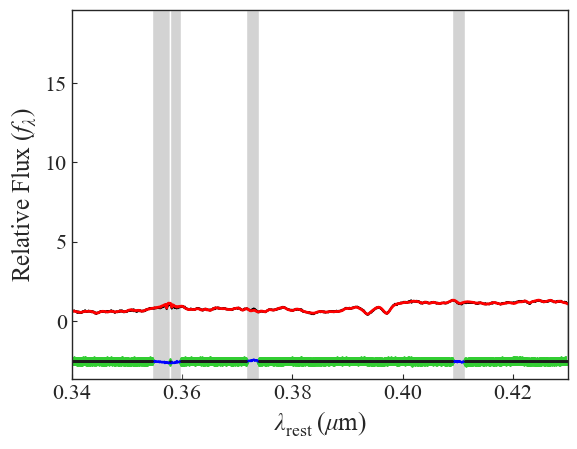

In [6]:
templates1, pp1, lamRange1, logLam1, lamRange2, logLam2, galaxy1, quasar1 = \
    ppxf_kinematics_RXJ1131_getGlobal_lens_deredshift(libary_dir,
                                                      degree=degree,
                                                      spectrum_aperture=spectrum_aperture,
                                                      wave_min=wave_min,
                                                      wave_max=wave_max,
                                                      velscale_ratio=velscale_ratio,
                                                      z=z,
                                                      noise=noise,
                                                      templates_name='xshooter',
                                                      FWHM=FWHM_gal,
                                                      FWHM_tem=FWHM_tem_xshooter,
                                                      quasar_spectrum=quasar_spectrum_A,
                                                      plot=True, temp_array=temp_all)
nTemplates1 = templates1.shape[1]
global_temp1 = templates1 @ pp1.weights[:nTemplates1]

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1386 1387 1388 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       286       304
chi2/DOF: 0.01291; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
   0.00725   0.00662
Formal errors:
     dV    dsigma   dh3      dh4
      33      35
Elapsed time in pPXF: 0.04 s


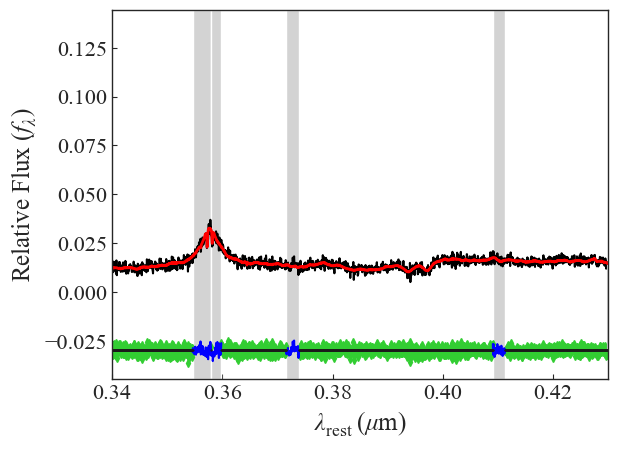

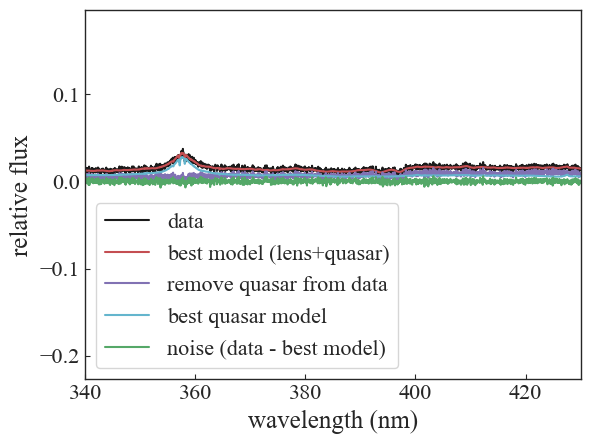

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1386 1387 1388 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       263       284
chi2/DOF: 0.01428; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0281   0.00326
Formal errors:
     dV    dsigma   dh3      dh4
     8.5     8.7
Elapsed time in pPXF: 0.05 s


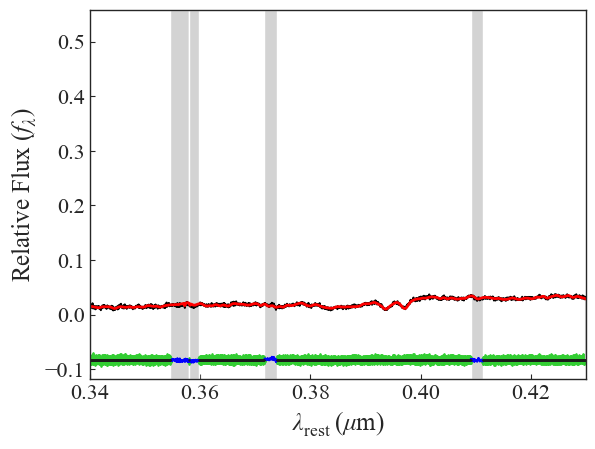

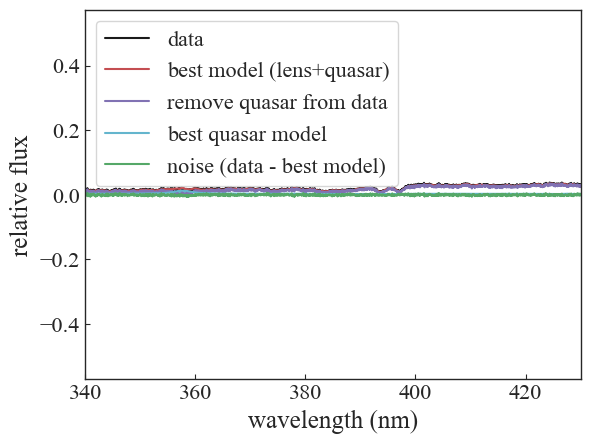

In [7]:
pix_1_y, pix_1_x, pix_2_y, pix_2_x = 16, 20, 23, 23 #, 16, 20
spectrum_perpixel1 = data_crop[0].data[:,pix_1_y, pix_1_x]
spectrum_perpixel2 = data_crop[0].data[:,pix_2_y, pix_2_x]

data_no_quasar1, noise1, sky1 = remove_quasar_from_galaxy_deredshift(libary_dir, 
             degree=degree, spectrum_aperture=spectrum_aperture, wave_min=wave_min,
             wave_max=wave_max, velscale_ratio=velscale_ratio, quasar_spectrum=quasar_spectrum_A,
             z=z, noise=noise, templates_name='xshooter', FWHM=FWHM_gal,
             FWHM_tem=FWHM_tem_xshooter, global_temp=global_temp1, plot=True,
             spectrum_perpixel=spectrum_perpixel1, random_plot=False)

data_no_quasar2, noise2, sky2 = remove_quasar_from_galaxy_deredshift(libary_dir, 
             degree=degree, spectrum_aperture=spectrum_aperture, wave_min=wave_min,
             wave_max=wave_max, velscale_ratio=velscale_ratio, quasar_spectrum=quasar_spectrum_A,
             z=z, noise=noise, templates_name='xshooter', FWHM=FWHM_gal,
             FWHM_tem=FWHM_tem_xshooter, global_temp=global_temp1, plot=True,
             spectrum_perpixel=spectrum_perpixel2, random_plot=False)

In [8]:
gal_lin1 = spectrum_perpixel1
lin_axis_sky = np.linspace(lamRange1[0], lamRange1[1], gal_lin1.size)
best_lin1 = spectrum_perpixel1 - noise1

gal_lin2 = spectrum_perpixel2
lin_axis_sky = np.linspace(lamRange1[0], lamRange1[1], gal_lin2.size)
best_lin2 = spectrum_perpixel2 - noise2

In [9]:
from matplotlib.collections import LineCollection


def get_all_edges(bool_img):
    """
    Get a list of all edges (where the value changes from True to False) in the 2D boolean image.
    The returned array edges has he dimension (n, 2, 2).
    Edge i connects the pixels edges[i, 0, :] and edges[i, 1, :].
    Note that the indices of a pixel also denote the coordinates of its lower left corner.
    """
    edges = []
    ii, jj = np.nonzero(bool_img)
    for i, j in zip(ii, jj):
        # North
        if j == bool_img.shape[1]-1 or not bool_img[i, j+1]:
            edges.append(np.array([[i, j+1],
                                   [i+1, j+1]]))
        # East
        if i == bool_img.shape[0]-1 or not bool_img[i+1, j]:
            edges.append(np.array([[i+1, j],
                                   [i+1, j+1]]))
        # South
        if j == 0 or not bool_img[i, j-1]:
            edges.append(np.array([[i, j],
                                   [i+1, j]]))
        # West
        if i == 0 or not bool_img[i-1, j]:
            edges.append(np.array([[i, j],
                                   [i, j+1]]))

    if not edges:
        return np.zeros((0, 2, 2))
    else:
        return np.array(edges)


def close_loop_edges(edges):
    """
    Combine thee edges defined by 'get_all_edges' to closed loops around objects.
    If there are multiple disconnected objects a list of closed loops is returned.
    Note that it's expected that all the edges are part of exactly one loop (but not necessarily the same one).
    """

    loop_list = []
    while edges.size != 0:

        loop = [edges[0, 0], edges[0, 1]]  # Start with first edge
        edges = np.delete(edges, 0, axis=0)

        while edges.size != 0:
            # Get next edge (=edge with common node)
            ij = np.nonzero((edges == loop[-1]).all(axis=2))
            if ij[0].size > 0:
                i = ij[0][0]
                j = ij[1][0]
            else:
                loop.append(loop[0])
                # Uncomment to to make the start of the loop invisible when plotting
                # loop.append(loop[1])
                break

            loop.append(edges[i, (j + 1) % 2, :])
            edges = np.delete(edges, i, axis=0)

        loop_list.append(np.array(loop))

    return loop_list


def plot_outlines(bool_img, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    edges = get_all_edges(bool_img=bool_img)
    edges = edges - 0.5  # convert indices to coordinates; TODO adjust according to image extent
    outlines = close_loop_edges(edges=edges)
    cl = LineCollection(outlines, **kwargs)
    ax.add_collection(cl)


/var/folders/ry/23z2z0bd7_d814t1jlq8ydlw0000gn/T/ipykernel_49364/1206582984.py:89: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.tight_layout()


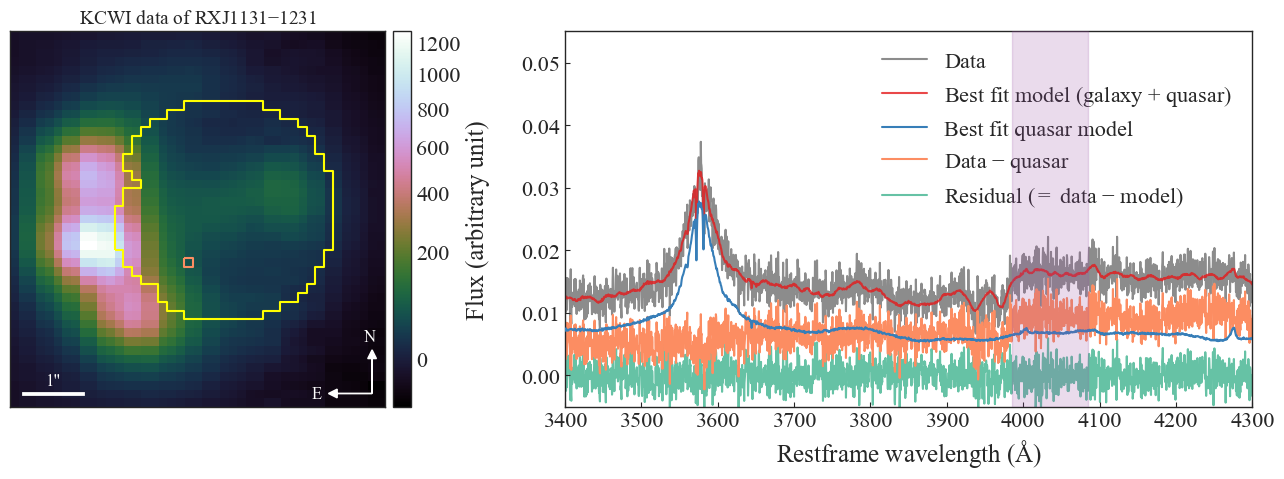

In [81]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


target_SN = 0.5

#fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
fig = plt.figure(figsize=(13, 5), constrained_layout=True)
gs = fig.add_gridspec(1, 5)
ax1 = fig.add_subplot(gs[0, :2])
ax2 = fig.add_subplot(gs[0, 2:])

ax = [[ax1, ax2]]

#fig.subplots_adjust(hspace=0)

norm = simple_norm(np.nansum(data_crop[0].data, axis=0), 'sqrt')
im = ax[0][0].imshow(np.nansum(data_crop[0].data, axis=0), origin='lower', norm=norm, cmap='cubehelix')

# rect1 = patches.Rectangle((pix_1_x, pix_1_y), 1, 1, linewidth=1, edgecolor='k', facecolor='k')
# rect2 = patches.Rectangle((pix_2_x, pix_2_y), 1, 1, linewidth=1, edgecolor='k', facecolor='k')

# Add the patch to the Axes
# ax[0][0].add_patch(rect1)
# ax[0][0].add_patch(rect2)

ax[0][0].set_title(r'KCWI data of RXJ1131$-$1231', fontsize=14)
ax[0][0].set_xticks([])
ax[0][0].set_yticks([])

plot_outlines(mask.T, ax=ax[0][0], lw=1.5, color='yellow')

rect1 = np.zeros_like(mask)
rect1[pix_1_x, pix_1_y] = 1
plot_outlines(rect1, ax=ax[0][0], lw=1.5, color=pf.cb2_orange)

divider = make_axes_locatable(ax[0][0])
cax = divider.append_axes('right', size='5%', pad='2%')
cbar = fig.colorbar(im, cax=cax, label='Flux (arbitrary unit)')

ax[0][0].arrow(41, 1, 0, 4,
         head_width=1, head_length=1, fc='white', ec='white', linewidth=1)
ax[0][0].arrow(41, 1, -4, 0,
         head_width=1, head_length=1, fc='white', ec='white', linewidth=1)
ax[0][0].text(40.7, 7, "N", color='white', fontsize=12, ha='center')
ax[0][0].text(34.7, 0.5, "E", color='white', fontsize=12, ha='center')

ax[0][0].arrow(1, 1, 1/0.1457, 0,
         head_width=0, head_length=0, fc='white', ec='white', linewidth=2)
ax[0][0].text(4.5, 2, '1\"', color='white', fontsize=12, ha='center')

    
# ax[1][0].imshow(mask*flux_per_AA, origin='lower', cmap='viridis')
# # im1 = ax[1][0].imshow(SN_per_AA, origin='lower', alpha=0.8)
# plt.colorbar(im1, ax = ax[1][0])

# ax[1][0].set_title('region selected for voronoi binning (S/N > %s)' % target_SN, fontsize=14)
# ax[1][0].set_xticks([])
# ax[1][0].set_yticks([])

ax[0][1].plot(lin_axis_sky, spectrum_perpixel1, c=pf.cb_grey, label='Data', alpha=0.6)
ax[0][1].plot(lin_axis_sky, best_lin1, '-', c=pf.cb_red, label='Best fit model (galaxy $+$ quasar)', alpha=0.8)
ax[0][1].plot(lin_axis_sky, sky1, '-', c=pf.cb_blue, label='Best fit quasar model', zorder=10)
ax[0][1].plot(lin_axis_sky, gal_lin1 - sky1, '-', c=pf.cb2_orange,
         label=r'Data $-$ quasar')
ax[0][1].plot(lin_axis_sky, gal_lin1 - best_lin1, '-', c=pf.cb2_emerald,
         label=r'Residual ($=$ data $-$ model)', zorder=-20)
#ax[0][1].set_title('Removing quasar contribution from data', fontsize=14)
ax[0][1].legend(frameon=False)
ax[0][1].set_xlabel(r'Restframe wavelength (${\rm \AA}$)')
#ax[0][1].set_ylabel('relative flux')
ax[0][1].set_xlim(wave_min*10000,wave_max*10000)
ax[0][1].set_ylim(-0.005, 0.055)
ax[0][1].axvspan(xmin=3985, xmax=4085, color=pf.cb_purple, zorder=30, alpha=0.2)


# ax[1][1].plot(lin_axis_sky/10, spectrum_perpixel2, 'k-', label='data')
# ax[1][1].plot(lin_axis_sky/10, best_lin2, 'r-', label='best fit model')
# # ax[1][1].plot(lin_axis_sky/10, gal_lin2 - sky2, 'm-',
# #          label='remove quasar from data')
# ax[1][1].plot(lin_axis_sky/10, sky2, 'c-',label='best fit quasar model')
# # ax[1][1].plot(lin_axis_sky/10, gal_lin2 - best_lin2, 'g-',
# #          label='noise (data - best model)')
# ax[1][1].legend()
# ax[1][1].set_xlabel('wavelength (nm)')
# ax[1][1].set_ylabel('relative flux')
# ax[1][1].set_xlim(wave_min*1000,wave_max*1000)
# ax[1][1].set_ylim(0.00, 0.04)

fig.tight_layout()
fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/rxj1131_kcwi/figures/vel_dis_extraction_area.pdf', 
            bbox_inches='tight'
           )

In [25]:
target_sn = 15

x, y, signal, noise_sig = np.loadtxt('../kcwi_extractions/extracted_dispersions/voronoi_2d_binning_KCWI_RXJ1131_icubes_mosaic_0.1457_arcsec_input.txt').T

classe, pixelsize = _accretion(
            x, y, signal, noise_sig, target_sn=target_sn, pixelsize=None, sn_func=_sn_func, quiet=1)


binNum, xnode, ynode, xBar, yBar, sn, nPixels, scale = voronoi_2d_binning(
        x, y, signal, noise_sig, target_sn=target_sn, plot=0, quiet=1)

classe, xBar, yBar, sn, area = _compute_useful_bin_quantities(
                             x, y, signal, noise_sig, xnode, ynode, scale, sn_func=_sn_func)
single = area == 1

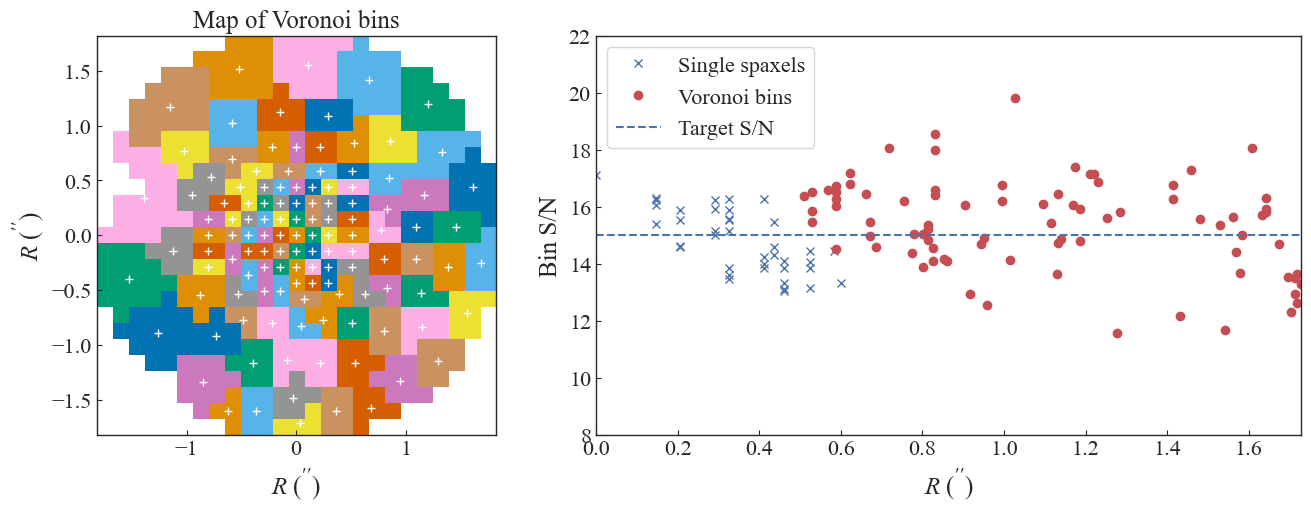

In [55]:
import seaborn as sns
from matplotlib.colors import ListedColormap

my_cmap = ListedColormap(sns.color_palette("colorblind", 20).as_hex()) #sns.color_palette('Set2', 12).as_hex())

fig = plt.figure(figsize=(13, 5), constrained_layout=True)
gs = fig.add_gridspec(1, 5)
ax1 = fig.add_subplot(gs[0, :2])
#f3_ax1.set_title('gs[0, :]')

# plt.figure(figsize=(8, 8))
# plt.subplot(211)
np.random.seed(112)
rnd = np.argsort(np.random.random(xnode.size))  # Randomize bin colors
_display_pixels(x, y, rnd[classe], pixelsize, cmap=my_cmap) #sns.color_palette('colorblind', as_cmap=True))
ax1.plot(xnode, ynode, '+w', scalex=False, scaley=False) # do not rescale after imshow()
ax1.set_xlabel(r'$R\ ({}^{\prime}{}^{\prime})$')
ax1.set_ylabel(r'$R\ ({}^{\prime}{}^{\prime})$')
ax1.set_title('Map of Voronoi bins')
ax1.set_aspect('equal')

# plt.subplot(212)
ax2 = fig.add_subplot(gs[0, 2:])
rad = np.sqrt(xBar**2 + yBar**2)  # Use centroids, NOT generators
# ax2.plot(np.sqrt(x**2 + y**2), signal/noise, '.k', label='Input S/N')
if np.any(single):
    ax2.plot(rad[single], sn[single], 'xb', label='Single spaxels')
ax2.plot(rad[~single], sn[~single], 'or', label='Voronoi bins')
ax2.set_xlabel(r'$R\ ({}^{\prime}{}^{\prime})$')
ax2.set_ylabel('Bin S/N')
ax2.axis([np.min(rad), np.max(rad), 0, np.max(sn)*1.05])  # x0, x1, y0, y1
ax2.plot([np.min(rad), np.max(rad)], [target_sn, target_sn], ls='--', label='Target S/N')
ax2.set_ylim(8, 22)

plt.legend()

fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/rxj1131_kcwi/figures/voronoi_binning_sn15.pdf', 
            bbox_inches='tight'
           )

## Plot spectra fits

In [13]:
name = "KCWI_RXJ1131_icubes_mosaic_0.1457"

voronoi_binning_data = fits.getdata('../kcwi_extractions/extracted_dispersions/' +'voronoi_binning_' + name + '_targetSN_15' + '_data.fits')

In [14]:
voronoi_binning_data.shape

(121, 5215)

In [15]:
voronoi_binning_data[100, :].shape

(5215,)

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1386 1387 1388 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       278       287
chi2/DOF: 0.01035; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 5; Func calls: 17; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0263    0.0035
Formal errors:
     dV    dsigma   dh3      dh4
     7.8       8
Elapsed time in pPXF: 0.04 s


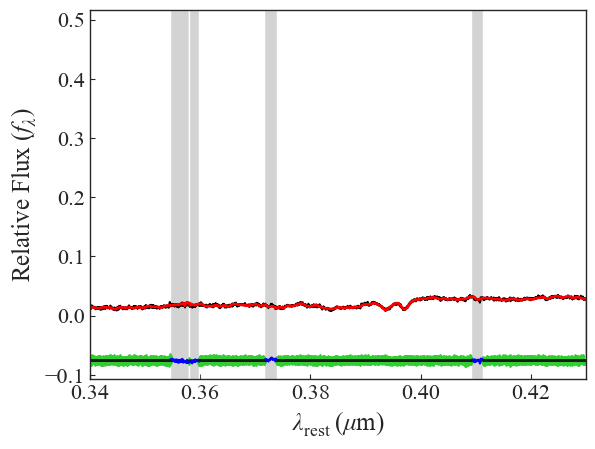

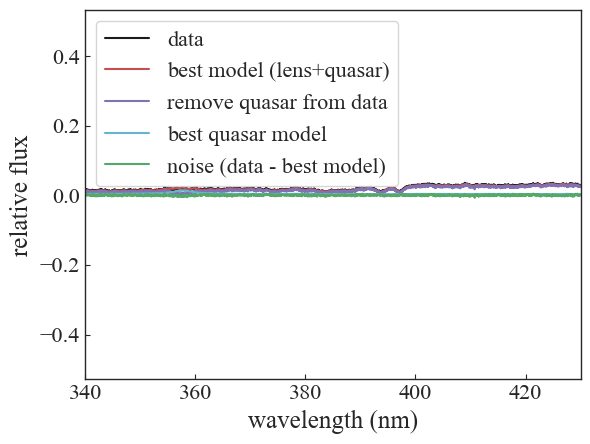

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1386 1387 1388 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       235       307
chi2/DOF: 0.1192; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0443    0.0118
Formal errors:
     dV    dsigma   dh3      dh4
      17      18
Elapsed time in pPXF: 0.02 s


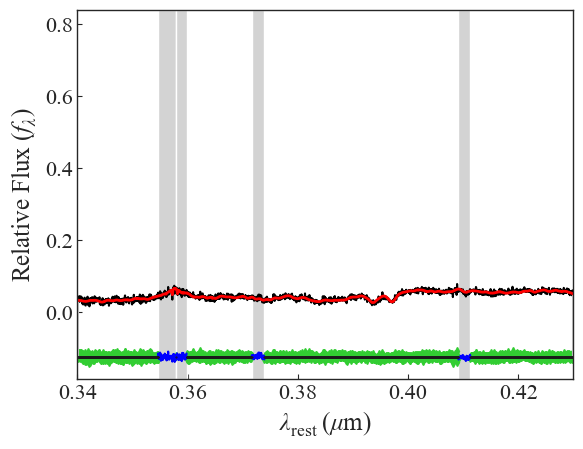

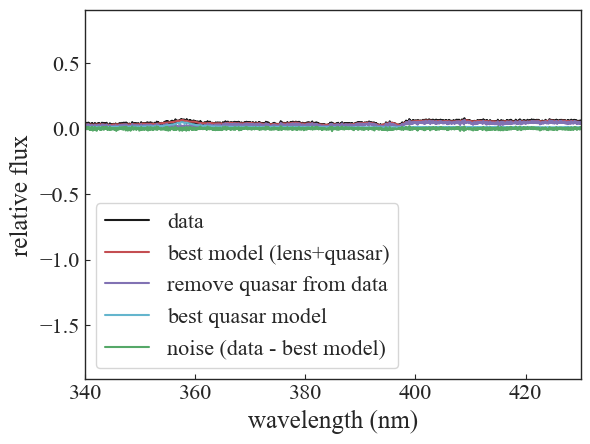

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1386 1387 1388 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       269       293
chi2/DOF: 0.03888; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 4; Func calls: 14; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0278      0.02
Formal errors:
     dV    dsigma   dh3      dh4
      15      15
Elapsed time in pPXF: 0.03 s


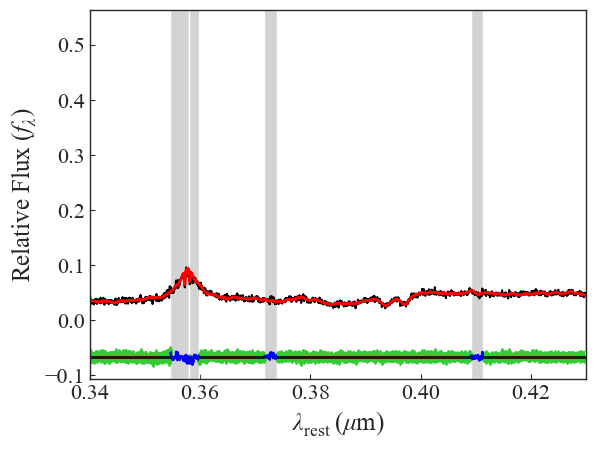

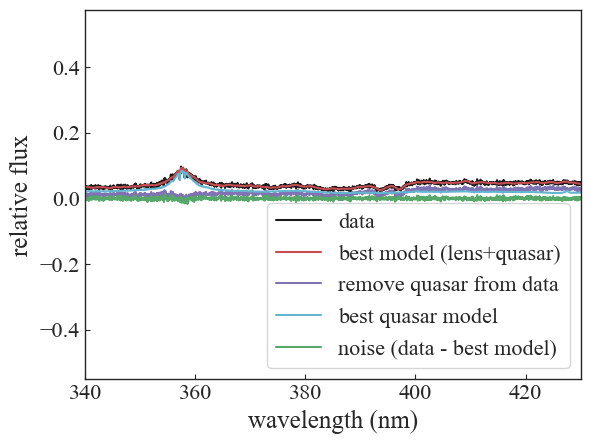

CRVAL1 is 3329.0
CDELT1 is 0.5
NAXIS1 is 5215 5215
velscale of the data is [33.25487436]
h2 = 0.14984130859375
velscale of the templates is [16.62743718]
[1386 1387 1388 ... 5212 5213 5214]
 Best Fit:       Vel     sigma
 comp.  0:       275       297
chi2/DOF: 0.2108; DOF: 1882; degree = 3; mdegree = 0
method = capfit; Jac calls: 3; Func calls: 11; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%): 2/2
Templates weights:
    0.0323    0.0683
Formal errors:
     dV    dsigma   dh3      dh4
      29      30
Elapsed time in pPXF: 0.02 s


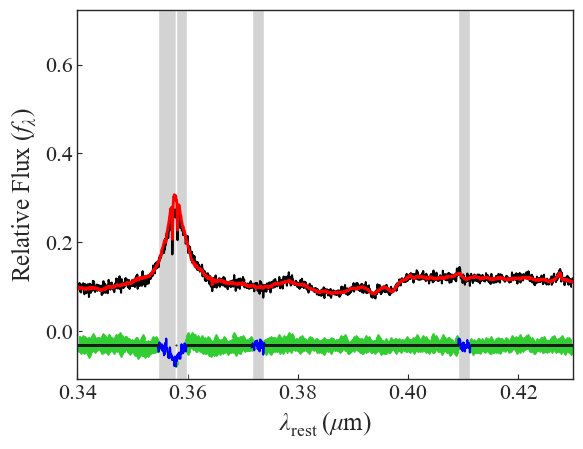

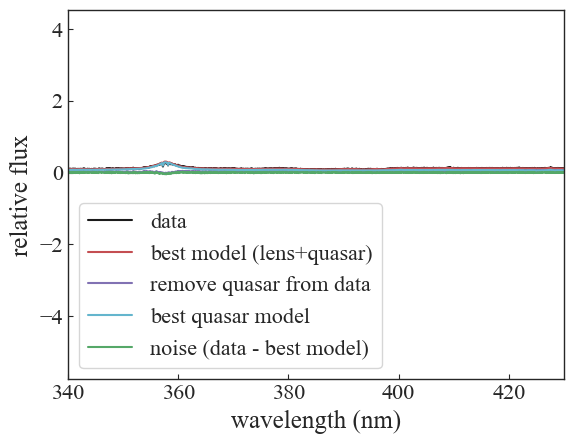

In [65]:
data_no_quasars = []
noises = []
skys = []

bins = [0, 30, 60, 100]

for i in bins:
    data_no_quasar_, noise_, sky_ = remove_quasar_from_galaxy_deredshift(libary_dir, 
                 degree=degree, spectrum_aperture=spectrum_aperture, wave_min=wave_min,
                 wave_max=wave_max, velscale_ratio=velscale_ratio, quasar_spectrum=quasar_spectrum_A,
                 z=z, noise=noise, templates_name='xshooter', FWHM=FWHM_gal,
                 FWHM_tem=FWHM_tem_xshooter, global_temp=global_temp1, plot=True,
                 spectrum_perpixel=voronoi_binning_data[i, :], random_plot=False)

    data_no_quasars.append(data_no_quasar_)
    noises.append(noise_)
    skys.append(sky_)

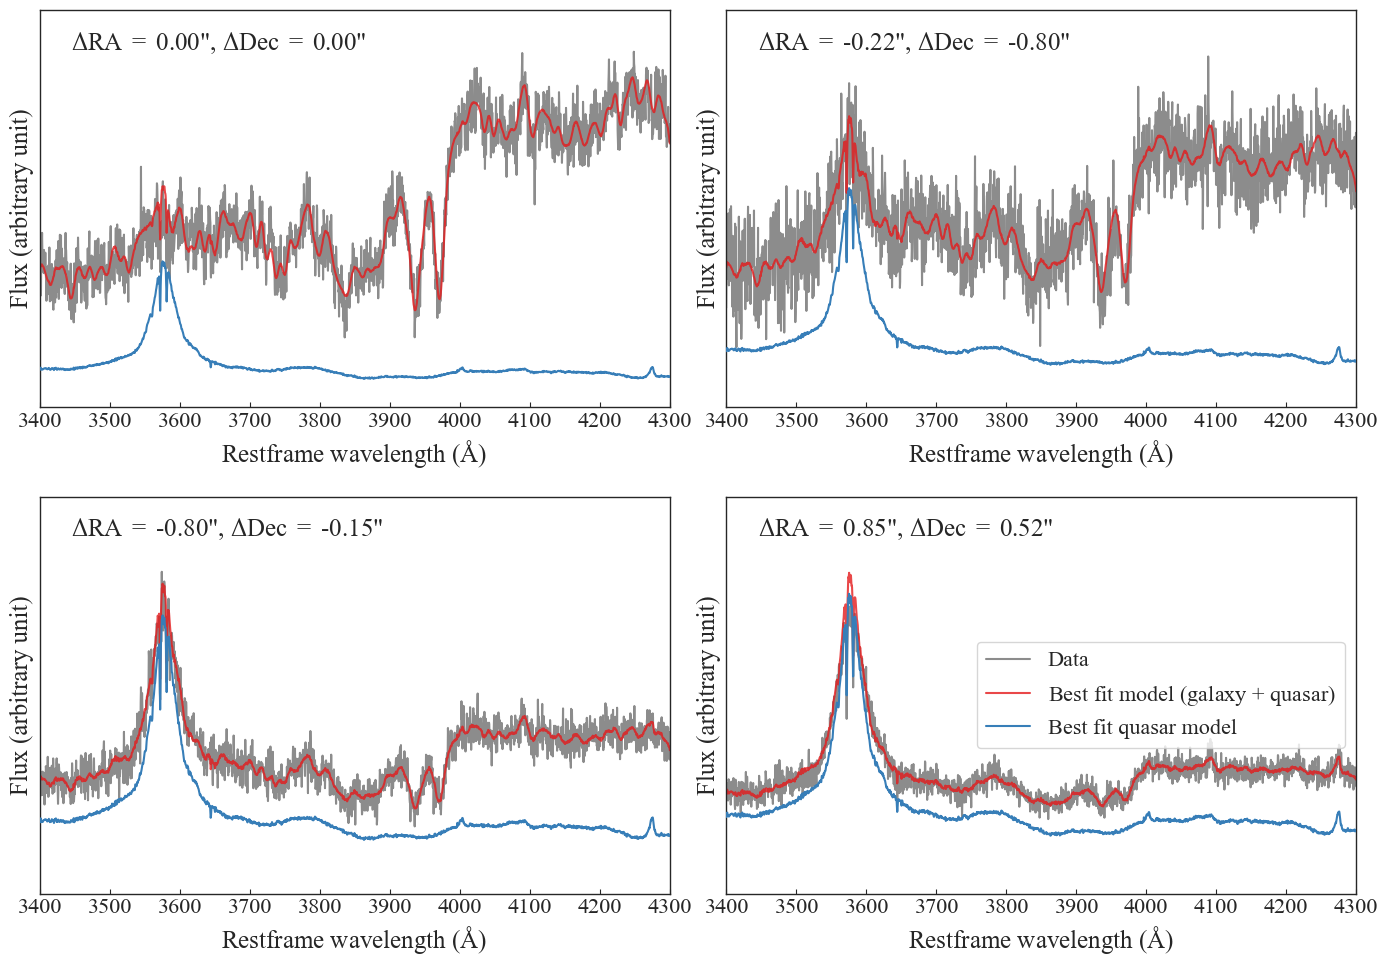

In [80]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

yranges_up = [0.04, 0.09, 0.12, .38]
yranges_down = [0, 0, 0, 0]

for i in range(2):
    for j in range(2):
        k = 2*i + j
        
        ax = axes[i][j]
        b = bins[k]
        
        data = voronoi_binning_data[b, :]
        lin_axis_sky = np.linspace(lamRange1[0], lamRange1[1], data.size)
        
        ax.plot(lin_axis_sky, voronoi_binning_data[b, :], c=pf.cb_grey, label='Data', alpha=0.6)
        ax.plot(lin_axis_sky, data - noises[k], '-', c=pf.cb_red, label='Best fit model (galaxy $+$ quasar)', alpha=0.8)
        ax.plot(lin_axis_sky, skys[k], '-', c=pf.cb_blue, label='Best fit quasar model', zorder=10)
#         ax.plot(lin_axis_sky, gal_lin1 - sky1, '-', c=pf.cb2_orange,
#                  label=r'data $-$ quasar')
#         ax.plot(lin_axis_sky, gal_lin1 - best_lin1, '-', c=pf.cb2_emerald,
#                  label=r'residual ($=$ data $-$ model)', zorder=-20)
        #ax.set_title('Removing quasar contribution from data', fontsize=14)
        #ax.legend(frameon=False)
        ax.set_xlabel(r'Restframe wavelength (${\rm \AA}$)')
        ax.set_ylabel('Flux (arbitrary unit)')
        ax.set_xlim(wave_min*10000, wave_max*10000)
        ax.set_ylim(yranges_down[k], yranges_up[k])
        ax.text(0.05, 0.9, 
                r'$\Delta$RA $=$ {:.2f}", $\Delta$Dec $=$ {:.2f}"'.format(xnode[b], ynode[b]),
                #'a',
                transform=ax.transAxes
               )
        #ax.axvspan(xmin=3985, xmax=4085, color=pf.cb_purple, zorder=30, alpha=0.2)
        ax.set_yticks([])
        
fig.tight_layout()
plt.legend(loc='center right')

fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/rxj1131_kcwi/figures/spectra_fitting.pdf', 
            bbox_inches='tight'
           )